In [1]:
import numpy as np
import nibabel as nb
import pandas as pd
import os.path as op
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

In [2]:
home_dir = '/home/despo/iballard/dopa/'
sub_list = np.loadtxt(op.join(home_dir,'subjects.txt'),str)
bad_subs = ['Da216'] #missing placebo fMRI
sub_list = [x for x in sub_list if x not in bad_subs]

sub_key = pd.read_csv(op.join(home_dir,
                              'data',
                              'session_drug_key.csv')).set_index(['subject','session'])


In [3]:
##load masks
mask_dir = '/home/despo/iballard/dopa/lags/shell_analysis/'
mask_ids = {'nacc':0,
            'nacc_1':1,
            'nacc_2':2,
            'nacc_3':3}
masks = {}
for mask in mask_ids.keys():
    masks[mask] = nb.load(op.join(mask_dir,
                        mask + '.nii.gz')).get_fdata().astype(bool)
    
mask

'nacc_3'

In [4]:
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/data/'
df = []
for sub in glob.glob(lag_dir + '/Da*'):
    
    
    sub_id = sub.split('/')[-1]
    
    try:
    
        sub_name = sub_id.split('_')[0]
        session = sub_id.split('_')[1]
        drug = sub_key.loc[(int(sub_name[2:]),int(session)),'drug']
        
        lag_map = op.join(sub,
                         'rapidtide_mask_gb_back_run_clean_afni_v5',
                         sub_id + '_rapidtide_mask_gb_back_clean_afni_v5_lagtimes.nii.gz')


        if op.exists(lag_map):
            lags = nb.load(lag_map).get_fdata()
            
            for mask in mask_ids.keys():
                

                roi_lags = lags[masks[mask]]
                roi_lags = [x for x in roi_lags if x!=0] #drop lags not in lag map (which have lag=0)
                median= np.median(roi_lags)
                
                sub_df = pd.DataFrame({'sub':sub_name,
                                      'session':session,
                                      'mask':mask,
                                      'lag':median*1000,
                                       'drug':drug,
                                       'distance':mask_ids[mask]
                                      }, index = [0])
                df.append(sub_df)
                
    except:
        print(sub)
df = pd.concat(df)

In [5]:
colors = ["#026c6d", "#f48888","#fcb7b7",'#efcbcb']
# Set your custom color palette
pal = sns.set_palette(sns.color_palette(colors))



distance
0    328.940617
1     69.059918
2   -220.571006
3   -509.789190
Name: lag, dtype: float64


/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0)` for the same effect.

  # Remove the CWD from sys.path while we load stuff.
/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.



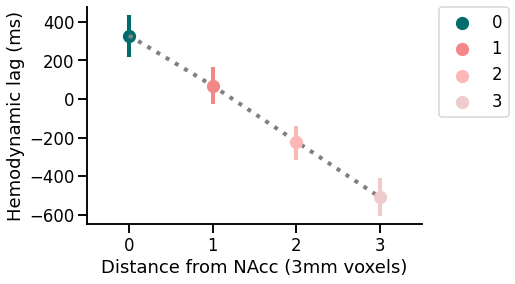

In [6]:
sns.set_context('talk')
fig_df = df[df['drug'] == 'plac']
print(fig_df.groupby('distance')['lag'].mean())
ax = sns.pointplot(x = 'distance',
             y = 'lag',
              color = 'grey',
             ci = 0,
              linestyles=':',
              palette = pal,
             data = fig_df)
points = ax.collections[0]
size = points.get_sizes().item()
new_sizes = [0 for name in ax.get_yticklabels()]
points.set_sizes(new_sizes)

sns.pointplot(x = 'distance',
             y = 'lag',
             ci = 68,
              hue = 'distance',
              palette = pal,
             data = fig_df,
             ax = ax)

sns.despine()
plt.ylabel('Hemodynamic lag (ms)')
plt.xlabel('Distance from NAcc (3mm voxels)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [7]:
df.to_csv('./final_csvs/shell_data_dopa.csv', index = False)

# Artery proximity analysis

In [8]:
artery = nb.load(op.join('/home/despo/iballard/dopa/lags/niftis/vesselProbs_2mm_susan_8mm_resampled.nii.gz')).get_fdata()
striatum = nb.load(op.join('/home/despo/iballard/dopa/lags/niftis/striatum_3mm.nii.gz')).get_fdata().astype(bool)
gm = nb.load(op.join('/home/despo/iballard/dopa/lags/niftis/MNI-maxprob-thr50-GM_3mm_bin.nii.gz')).get_fdata().astype(bool)

artery = artery[gm]

In [9]:
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/data/'
art_df = []
for sub in glob.glob(lag_dir + '/Da*'):
    
    
    sub_id = sub.split('/')[-1]
        
    sub_name = sub_id.split('_')[0]
    session = sub_id.split('_')[1]
    drug = sub_key.loc[(int(sub_name[2:]),int(session)),'drug']

    lag_map = op.join(sub,
                     'rapidtide_mask_gb_back_run_clean_afni_v5',
                     sub_id + '_rapidtide_mask_gb_back_clean_afni_v5_lagtimes.nii.gz')


    if op.exists(lag_map):
        lags = nb.load(lag_map).get_fdata()


        lags= lags[gm]

        corr = scipy.stats.spearmanr(lags,artery)[0]


        sub_df = pd.DataFrame({'sub':sub_name,
                              'session':session,
                              'corr':corr,
                               'drug':drug,
                              }, index = [0])
        art_df.append(sub_df)

art_df = pd.concat(art_df)
art_df.to_csv('./final_csvs/artery_data.csv', 
              index = False)

Text(-38.625, 0.5, 'Lag correlation\nwith artery proximity')

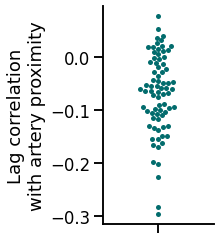

In [10]:
sns.set_context('talk')
f, ax = plt.subplots(figsize=(2,4))


art_df = art_df[art_df['drug'] == 'plac']
sns.swarmplot(
             y = 'corr',
    data = art_df)
sns.despine()
plt.ylabel('Lag correlation\nwith artery proximity')


In [11]:
mask_dir = '/home/despo/iballard/dopa/lags/shell_analysis'
mask_ids = {'nacc_3mm':0,
            'nacc_caud_1':1,
            'nacc_caud_2':2,
            'nacc_caud_3':3,
           'nacc_caud_4':4,
           'nacc_put_1':1,
            'nacc_put_2':2,
            'nacc_put_3':3,
           'nacc_put_4':4}
masks = {}
for mask in mask_ids.keys():
    if 'caud' in mask:
        masks[mask] = nb.load(op.join(mask_dir,
                                      'caudate_border',
                            mask + '.nii.gz')).get_fdata().astype(bool)
    else:
        masks[mask] = nb.load(op.join(mask_dir,
                                      'putamen_border',
                            mask + '.nii.gz')).get_fdata().astype(bool)

In [12]:
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/data/'
df = []
for sub in glob.glob(lag_dir + '/Da*'):
    
    
    sub_id = sub.split('/')[-1]
    
    try:
    
        sub_name = sub_id.split('_')[0]
        session = sub_id.split('_')[1]
        drug = sub_key.loc[(int(sub_name[2:]),int(session)),'drug']
        
        lag_map = op.join(sub,
                         'rapidtide_mask_gb_back_run_clean_afni_v5',
                         sub_id + '_rapidtide_mask_gb_back_clean_afni_v5_lagtimes.nii.gz')


        if op.exists(lag_map):
            lags = nb.load(lag_map).get_fdata()
            
            for mask in mask_ids.keys():
                
                if mask == 'nacc_3mm':
                    roi = 'nacc'
                elif 'caud' in mask:
                    roi = 'caudate'
                elif 'put' in mask:
                    roi = 'putamen'
                    
                
                roi_lags = lags[masks[mask]]
                roi_lags = [x for x in roi_lags if x!=0] #drop lags not in lag map (which have lag=0)
                median= np.median(roi_lags)

                
                sub_df = pd.DataFrame({'sub':sub_name,
                                      'session':session,
                                      'mask':roi,
                                      'lag':median*1000,
                                       'drug':drug,
                                       'distance':mask_ids[mask]
                                      }, index = [0])
                df.append(sub_df)
                
    except:
        print(sub)
df = pd.concat(df)

/home/despoC/iballard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  if __name__ == '__main__':


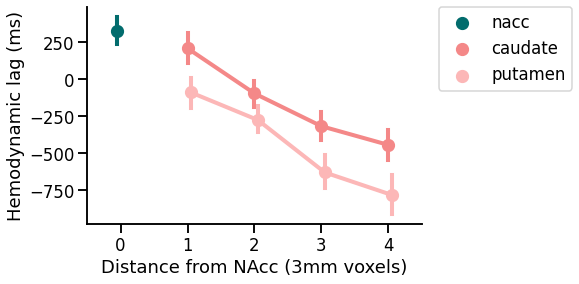

In [13]:
sns.set_context('talk')
df = df[df['drug'] == 'plac']
sns.pointplot(x = 'distance',
             y = 'lag',
             hue = 'mask',
             ci = 68,
#              join = False,
              dodge = .1,
             data = df)
sns.despine()
plt.ylabel('Hemodynamic lag (ms)')
plt.xlabel('Distance from NAcc (3mm voxels)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [14]:
df.to_csv('./final_csvs/border_data.csv', index = False)

In [15]:
##load masks
mask_dir = '/home/despo/iballard/dopa/lags/3mm_masks//'
mask_ids = ['nacc_3mm',
            'putamen_3mm',
            'caudate_3mm',
           'S1_3mm',
           'OT_3mm']
masks = {}
for mask in mask_ids:
    masks[mask] = nb.load(op.join(mask_dir,
                        mask + '.nii.gz')).get_fdata().astype(bool)
    

In [16]:
# lag_path = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/output_csvs/'
lag_dir = '/home/despo/ioannis/Berkeley_research1/Daniella/dopamine/lags/data/'
df = []
for sub in glob.glob(lag_dir + '/Da*'):
    
    
    sub_id = sub.split('/')[-1]
    
    try:
    
        sub_name = sub_id.split('_')[0]
        session = sub_id.split('_')[1]
        drug = sub_key.loc[(int(sub_name[2:]),int(session)),'drug']
        
        lag_map = op.join(sub,
                         'rapidtide_mask_gb_back_run_clean_afni_v5',
                         sub_id + '_rapidtide_mask_gb_back_clean_afni_v5_lagtimes.nii.gz')


        if op.exists(lag_map):
            lags = nb.load(lag_map).get_fdata()
            
            for mask in mask_ids:
               
                    
                roi_lags = lags[masks[mask]]
                roi_lags = [x for x in roi_lags if x!=0] #drop lags not in lag map (which have lag=0)
                median= np.median(roi_lags)
                
                sub_df = pd.DataFrame({'sub':sub_name,
                                      'session':session,
                                      'mask':mask.split('_')[0],
                                      'lag':median*1000,
                                       'drug':drug,
                                      }, index = [0])
                df.append(sub_df)
                
    except:
        print(sub)
df = pd.concat(df)

In [17]:
df.to_csv('./final_csvs/striatum_region_lag_data.csv', index = False)